<a href="https://colab.research.google.com/github/pippa28/GoogleCollab/blob/main/BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem**
To predict a number of survival months based on various clinical and demographic features. Additionally, predicting how long a patient will survive.

Importing libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Loading in the Breast Cancer dataset

In [2]:
data = pd.read_csv('/content/Breast_Cancer.csv')

In [3]:
data.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [4]:
#Check for any missing values
print("\nMissing Values:")
print(data.isnull().sum())

#Fill in any missing values if any
data.fillna(data.mode().iloc[0],inplace=True)


Missing Values:
Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64


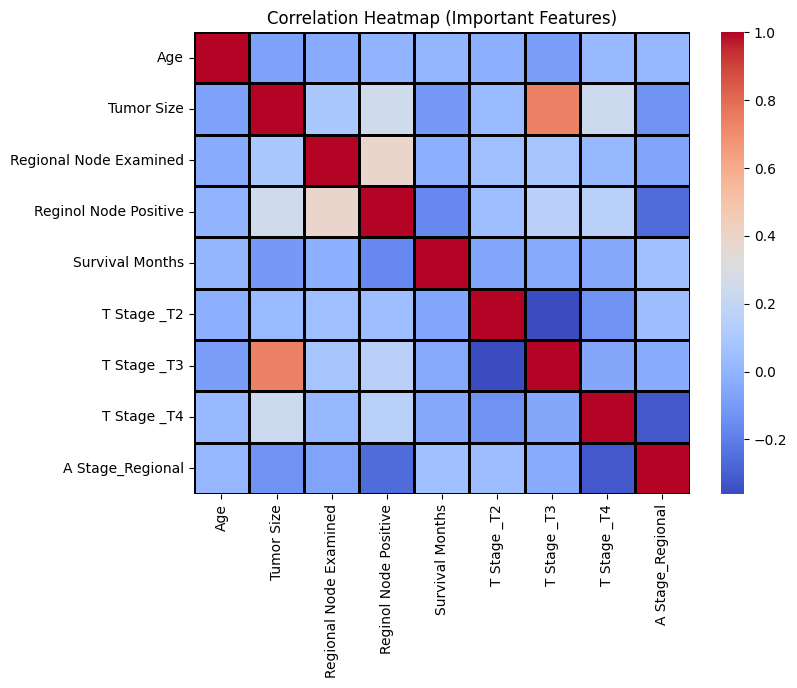

                             Age  Tumor Size  Regional Node Examined  \
Age                     1.000000   -0.078359               -0.037443   
Tumor Size             -0.078359    1.000000                0.097494   
Regional Node Examined -0.037443    0.097494                1.000000   
Reginol Node Positive  -0.002312    0.253253                0.386856   
Survival Months         0.010286   -0.108828               -0.020921   
T Stage _T2            -0.023270    0.027461                0.050245   
T Stage _T3            -0.087589    0.734336                0.076569   
T Stage _T4             0.023905    0.232960                0.020434   
A Stage_Regional        0.012030   -0.129075               -0.066502   

                        Reginol Node Positive  Survival Months  T Stage _T2  \
Age                                 -0.002312         0.010286    -0.023270   
Tumor Size                           0.253253        -0.108828     0.027461   
Regional Node Examined               0.386

In [5]:
# Limit the number of rows to speed up the calculation (optional)
data_sample = data.sample(n=2000, random_state=42)  # Randomly sample 500 rows (adjust as needed)

# Select a subset of important features (adjust according to actual column names)
important_features = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive','Survival Months','T Stage ', 'A Stage']

# Convert categorical columns to numeric using pd.get_dummies() for the important features
data_encoded = pd.get_dummies(data_sample[important_features], drop_first=True)

# Plot the correlation heatmap (only for selected important features)
plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
correlation_matrix = data_encoded.corr()  # Calculate correlations for the selected columns
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=1, linecolor='black')
plt.title("Correlation Heatmap (Important Features)")
plt.show()
print(correlation_matrix)

In [6]:
print(data.columns)  # This will list all columns to see if 'race' e

Index(['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')


In [7]:
# Remove the 'T' character from 'T stage' column
data['T Stage '] = data['T Stage '].str.replace('T', '', regex=False)

In [8]:
print(data['Grade'].unique())


['3' '2' '1' ' anaplastic; Grade IV']


In [9]:
# Define stage order from least to most severe
stage_order = ['IIA', 'IIIA', 'IIIC', 'IIB', 'IIIB']
# Map stages to numeric values based on order
stage_mapping = {stage: idx for idx, stage in enumerate(stage_order)}

# Apply mapping
data['6th Stage'] = data['6th Stage'].map(stage_mapping)

# Check results
print(data['6th Stage'].head())


# Update the mapping dictionary to include 'Undifferentiated'
differentiate_mapping = {
    'Poorly differentiated': 0,
    'Moderately differentiated': 1,
    'Well differentiated': 2,
    'Undifferentiated': 3
}

# Apply the mapping
data['differentiate'] = data['differentiate'].map(differentiate_mapping)


# Check the result
print(data['differentiate'].head())

# Clean the 'Grade' column by splitting on ';' and keeping the relevant part
data['Grade'] = data['Grade'].apply(lambda x: str(x).split(';')[0].strip())

# Map the 'Grade' values to numerical values
grade_mapping = {'3': 2, '2': 3, '1': 4, 'anaplastic': 0, 'Grade IV': 1}

# Apply the mapping
data['Grade'] = data['Grade'].map(grade_mapping)

# Check the result
print(data['Grade'].unique())  # Check the unique values in the Grade column



0    0
1    1
2    2
3    0
4    3
Name: 6th Stage, dtype: int64
0    0
1    1
2    1
3    0
4    0
Name: differentiate, dtype: int64
[2 3 4 0]


In [10]:


# 3. Define categorical columns to encode
categorical_cols = ['Race', 'Marital Status', 'T Stage ', 'N Stage',
                    'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']

# 4. Encode categorical variables using LabelEncoder
label_encoders = {}

for col in categorical_cols:
    if col in data.columns:  # Check column exists
        le = LabelEncoder()

        # Handle missing values by replacing them with a placeholder
        data[col] = data[col].fillna("Unknown")

        # Convert column to string for consistency and fit-transform with LabelEncoder
        data[col] = le.fit_transform(data[col].astype(str))

        # Store the encoder for future inverse transforms
        label_encoders[col] = le

# 5. Display the first few rows of the encoded categorical columns
print("✅ Successfully encoded categorical columns!")
print(data[categorical_cols].head())


✅ Successfully encoded categorical columns!
   Race  Marital Status  T Stage   N Stage  A Stage  Estrogen Status  \
0     2               1         0        0        1                1   
1     2               1         1        1        1                1   
2     2               0         2        2        1                1   
3     2               1         0        0        1                1   
4     2               1         1        0        1                1   

   Progesterone Status  Status  
0                    1       0  
1                    1       0  
2                    1       0  
3                    1       0  
4                    1       0  


In [11]:
# Scaling numerical variables
numerical_cols = ['age', 'tumor_size', 'regional_node_examined', 'reginol_node_positive']
numerical_cols = [col for col in numerical_cols if col in data.columns]  # Ensure columns exist

if numerical_cols:  # Check if there are numerical columns before scaling
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the scaled data
print(data.head())

   Age  Race  Marital Status  T Stage   N Stage  6th Stage  differentiate  \
0   68     2               1         0        0          0              0   
1   50     2               1         1        1          1              1   
2   58     2               0         2        2          2              1   
3   58     2               1         0        0          0              0   
4   47     2               1         1        0          3              0   

   Grade  A Stage  Tumor Size  Estrogen Status  Progesterone Status  \
0      2        1           4                1                    1   
1      3        1          35                1                    1   
2      3        1          63                1                    1   
3      2        1          18                1                    1   
4      2        1          41                1                    1   

   Regional Node Examined  Reginol Node Positive  Survival Months  Status  
0                      24         

In [12]:
# Define features (X) and target (y)
X = data.drop(columns=['Status', 'Survival Months'])  # Features
y = data['Status']  # Target (Survival Status)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(X_train.select_dtypes(include='object').columns)  # Should return an empty Index


Index([], dtype='object')


In [14]:
# Model selection and training
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [15]:
# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Accuracy Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       685
           1       0.62      0.17      0.26       120

    accuracy                           0.86       805
   macro avg       0.75      0.57      0.59       805
weighted avg       0.83      0.86      0.82       805

Confusion Matrix:
 [[673  12]
 [100  20]]
Accuracy Score: 0.8608695652173913


                   Feature  Importance
0                      Age    0.194061
12  Regional Node Examined    0.188127
9               Tumor Size    0.182513
13   Reginol Node Positive    0.128336
2           Marital Status    0.067296
1                     Race    0.034122
3                 T Stage     0.033616
4                  N Stage    0.033469
11     Progesterone Status    0.029652
7                    Grade    0.026957
5                6th Stage    0.025737
6            differentiate    0.024542
10         Estrogen Status    0.023495
8                  A Stage    0.008076


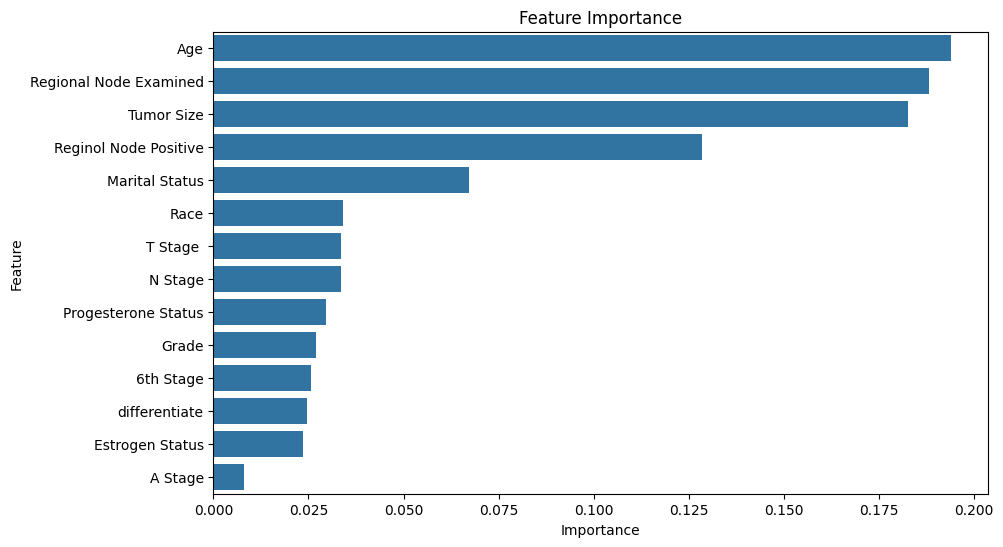

In [16]:
# Feature importance (which features contributed most to the decision-making)
feature_importances = model.feature_importances_

# Create a DataFrame to display the feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(features_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.show()